# 6\.1 Preparing the DataSet

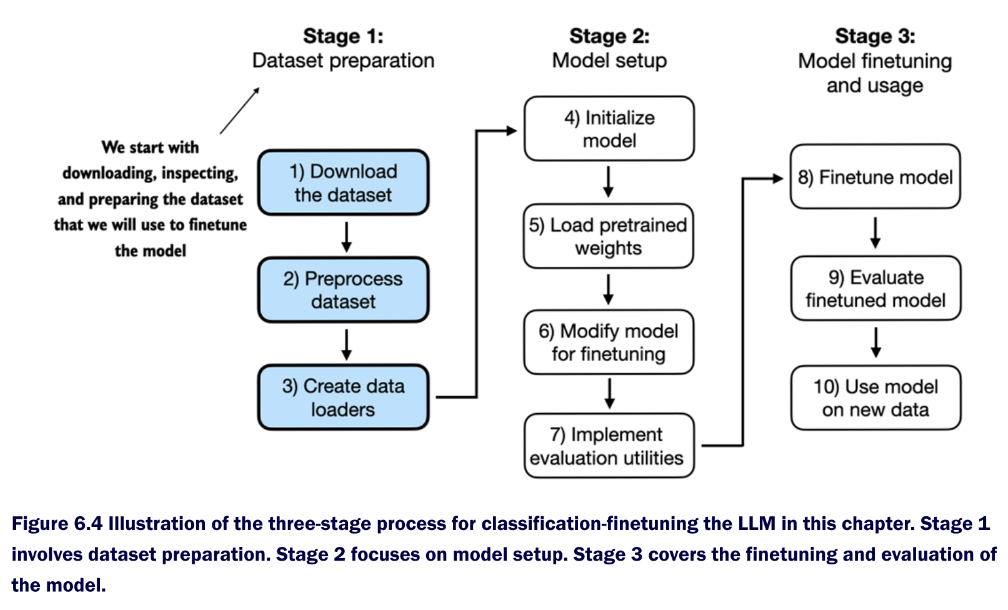

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = 'sms_spam_collection.zip'
extracted_path = 'sms_spam_collection'
data_file_path = Path(extracted_path)/"SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path
):
  if data_file_path.exists():
    print(f'{data_file_path} already exists. Skipping ownload and extraction')
    return

  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
      out_file.write(response.read())
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

  original_file_path = Path(extracted_path)/'SMSSpamCollection'
  os.rename(original_file_path, data_file_path)
  print(f'File downloaded and saved as {data_file_path}')

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

In [ ]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv(data_file_path, sep='\t', header=None, names=['label', 'message'])

df

In [ ]:
print(df['label'].value_counts())

In [ ]:
# risolvere la mancanza di equiibrio nelle classi

def create_balanced_dataset(df):
  num_spam = df[df['label'] == 'spam'].shape[0]
  ham_subset = df[df['label'] == 'ham'].sample(
      num_spam, random_state = 123
  )
  balanced_df = pd.concat([
      ham_subset, df[df['label']=='spam']
  ])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['label'].value_counts())

In [ ]:
# convertire le etichette 'spam' e 'ham' in valori numerivi
balanced_df['label'] = balanced_df['label'].map({'ham':0, 'spam':1})

In [ ]:
# creiamo una funzione per dividere il dataset
def random_split(df, train_frac, validation_frac):
  df = df.sample(
      frac = 1, random_state = 123
  ).reset_index(drop = True)
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1
)

In [ ]:
# salvare i dataset in csv
train_df.to_csv('train.csv', index = None)
validation_df.to_csv('validation.csv', index = None)
test_df.to_csv('test.csv', index = None)

## 6\.1\.1 Creating the dataset and the dataloader

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

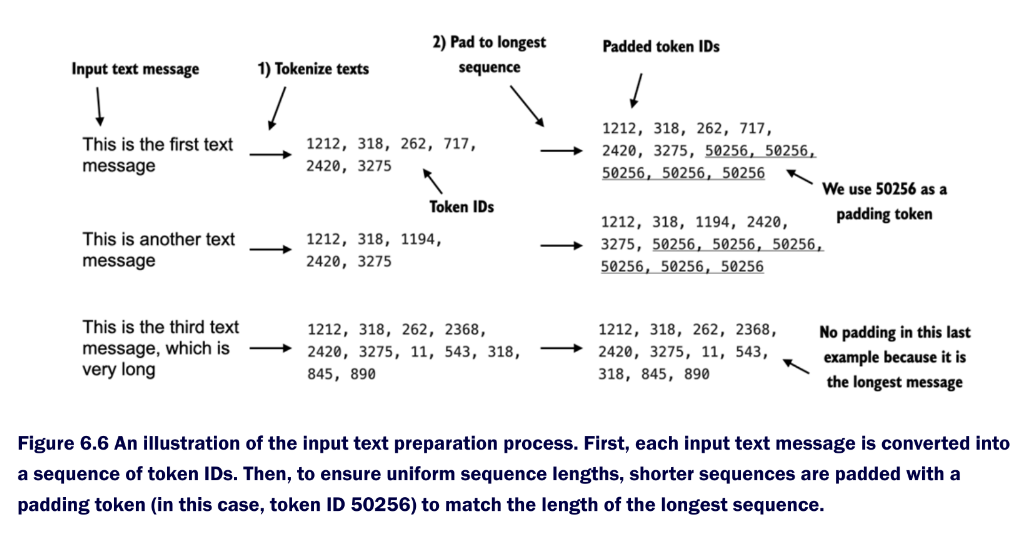

In [ ]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length = None, pad_token = 50256):
    self.data = pd.read_csv(csv_file)
    # tokenizza il testo
    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data['message']
    ]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # tronca le sequenze troppo lunghe
      self.encoded_texts = [
          encoded_text[:self.max_length]
          for encoded_text in self.encoded_texts
      ]

    self.encoded_texts = [
        # riempie le sequenze piu corte con il token end_of_text
        encoded_text + [pad_token] *(self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
        ]

  def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]['label']
    return (
        torch.tensor(encoded, dtype = torch.long),
        torch.tensor(label, dtype = torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length
    return max_length

In [ ]:
train_dataset = SpamDataset(
    csv_file = 'train.csv',
    max_length = None,
    tokenizer = tokenizer
)

In [ ]:
val_dataset = SpamDataset(
    csv_file = 'validation.csv',
    max_length = None,
    tokenizer = tokenizer
)

In [ ]:
test_dataset = SpamDataset(
    csv_file = 'test.csv',
    max_length = None,
    tokenizer = tokenizer
)

In questo modo tutte le sequenze nel dataset hanno la stessa lunghezza in token.

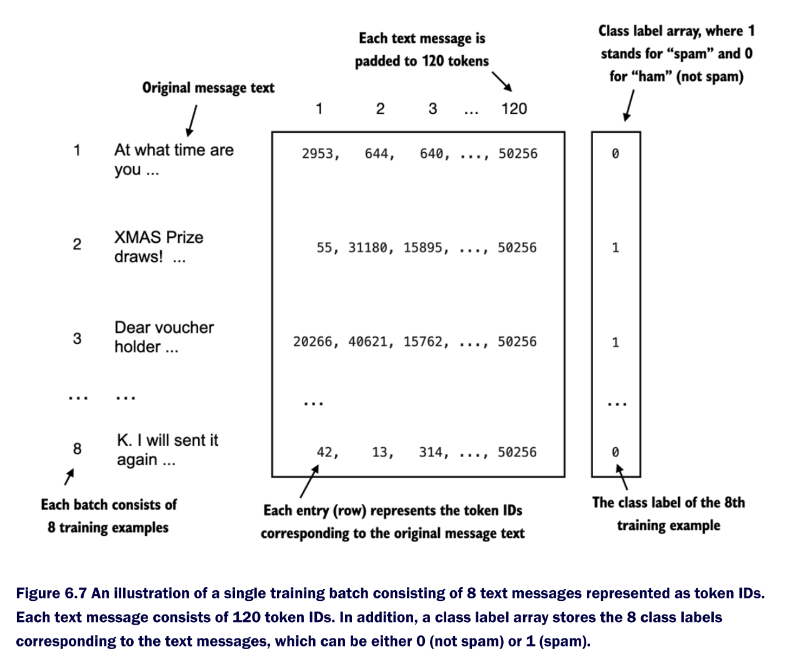

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True # drop the last batch if it is too short
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = False
)

In [ ]:
# test
for input_batch, target_batch in train_loader:
  pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

# 6\.2 Preparing the model

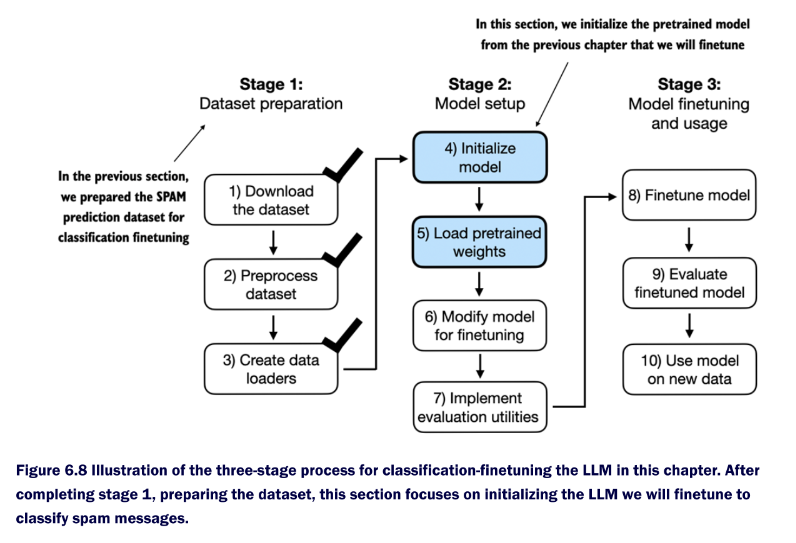

In [ ]:
import torch.nn as nn
import torch

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 256,
    "emb_dim" : 768, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 12, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 12,
    "drop_rate" : 0.1, # dropout regularization
    "qvb_bias" : False # query-key-value bias
}

In [ ]:
# implementazione del layer di normalizzazione
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # per evitare di dividere per zero
    self.scale = nn.Parameter(torch.ones(emb_dim)) # parametri aggiuntivi allenabili
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # parametri aggiunti allenabili

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * x + self.shift # operazioni elemento per elemento

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x+0.044715*torch.pow(x,3))
    ))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# mha module
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
# trasformer block
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qvk_bias"] # Use 'qvk_bias' from config
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x

    # attention module
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    # feed-forward network
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x) # linear layer --> GELU --> linear layer
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    return x

In [ ]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
          *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape

    # creazione token di input con poitional encoding
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds

    # dropout layer
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
CHOOSE_MODEL = 'gpt2-small (124M)'
INPUT_PROMPT = 'Every effort moves'

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qvk_bias': True
    }

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
import numpy as np
def load_weights_into_gpt(gpt, params):
  device = gpt.pos_emb.weight.device # Get the device of the model parameters
  gpt.pos_emb.weight.data = torch.tensor(params['wpe'], dtype=gpt.pos_emb.weight.dtype, device=device) #A
  # Explicitly convert and assign wte to embedding and output head
  wte_tensor = torch.tensor(params['wte'], dtype=gpt.tok_emb.weight.dtype, device=device)
  gpt.tok_emb.weight.data = wte_tensor
  gpt.out_head.weight.data = wte_tensor #D

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    #B
    #C
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight.data = torch.tensor(q_w.T, dtype=gpt.trf_blocks[b].att.W_query.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_key.weight.data = torch.tensor(k_w.T, dtype=gpt.trf_blocks[b].att.W_key.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_value.weight.data = torch.tensor(v_w.T, dtype=gpt.trf_blocks[b].att.W_value.weight.dtype, device=device)

    if gpt.trf_blocks[b].att.W_query.bias is not None: # Check if bias exists
      q_b, k_b, v_b = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
      gpt.trf_blocks[b].att.W_query.bias.data = torch.tensor(q_b, dtype=gpt.trf_blocks[b].att.W_query.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_key.bias.data = torch.tensor(k_b, dtype=gpt.trf_blocks[b].att.W_key.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_value.bias.data = torch.tensor(v_b, dtype=gpt.trf_blocks[b].att.W_value.bias.dtype, device=device)

    gpt.trf_blocks[b].att.out_proj.weight.data = torch.tensor(
    params["blocks"][b]["attn"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].att.out_proj.weight.dtype, device=device)
    if gpt.trf_blocks[b].att.out_proj.bias is not None: # Check if bias exists
      gpt.trf_blocks[b].att.out_proj.bias.data = torch.tensor(
      params["blocks"][b]["attn"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].att.out_proj.bias.dtype, device=device)

    gpt.trf_blocks[b].ff.layers[0].weight.data = torch.tensor(
                                                  params["blocks"][b]["mlp"]["c_fc"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[0].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[0].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_fc"]["b"], dtype=gpt.trf_blocks[b].ff.layers[0].bias.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].weight.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[2].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].ff.layers[2].bias.dtype, device=device)

    gpt.trf_blocks[b].norm1.scale.data = torch.tensor(
    params["blocks"][b]["ln_1"]["g"], dtype=gpt.trf_blocks[b].norm1.scale.dtype, device=device)
    gpt.trf_blocks[b].norm1.shift.data = torch.tensor(
    params["blocks"][b]["ln_1"]["b"], dtype=gpt.trf_blocks[b].norm1.shift.dtype, device=device)
    gpt.trf_blocks[b].norm2.scale.data = torch.tensor(
    params["blocks"][b]["ln_2"]["g"], dtype=gpt.trf_blocks[b].norm2.scale.dtype, device=device)
    gpt.trf_blocks[b].norm2.shift.data = torch.tensor(
    params["blocks"][b]["ln_2"]["b"], dtype=gpt.trf_blocks[b].norm2.shift.dtype, device=device)

  gpt.final_norm.scale.data = torch.tensor(params["g"], dtype=gpt.final_norm.scale.dtype, device=device)
  gpt.final_norm.shift.data = torch.tensor(params["b"], dtype=gpt.final_norm.shift.dtype, device=device)

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

In [ ]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(')')
settings, params = download_and_load_gpt2(
    model_size = model_size, models_dir = 'gpt2'
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):

  for _ in range(max_new_tokens): # genera un massimo di max_new_tokens parole
    idx_cond = idx[:, -context_size:] # vengono considerati gli ultimi context_size elementi della serie generata
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :] # si considera l'ultimo vettore di logit nella sequenza di output per la generazione del prossimo token
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

In [ ]:
# implementiamo delle funzioni che ci serviranno da qui in avanti
import tiktoken

# prende il testo e lo converte in vettori one-hot di dimensione pari a quella del dizionario considerato
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # added batch dimension
  return encoded_tensor

# fa il contrario della funzione di prima (token --> testo)
def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [ ]:
text_1 = 'Every effort moves you'
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG['context_length']
)
print(token_ids_to_text(token_ids, tokenizer))

# 6\.3 Text Classification

Per prima cosa proviamo a capire se il modello gia riesce a seguire le istruzioni in input.

In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been especially selected to receive $1000 cash or a $2000 award'"
)
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_2, tokenizer),
    max_new_tokens = 23,
    context_size=BASE_CONFIG['context_length']
)
print(token_ids_to_text(token_ids, tokenizer))

Chiaramente non risponde come ci si aspettarebbe.

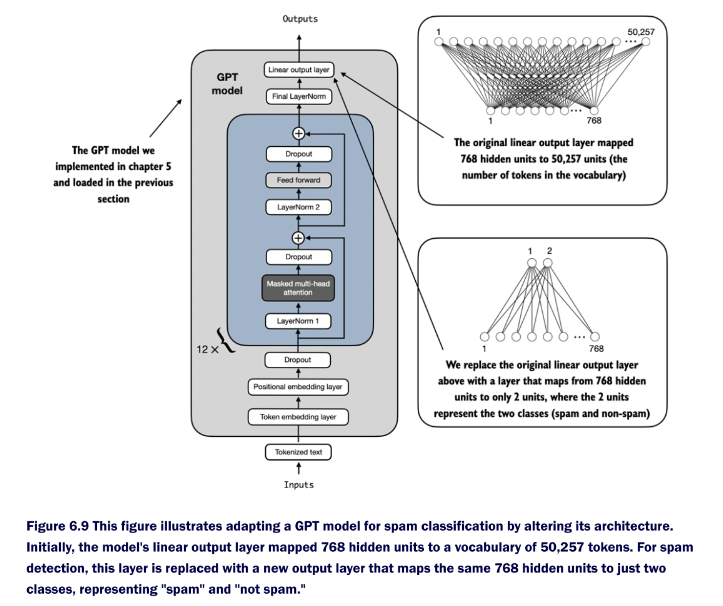

In [ ]:
print(model)

In [ ]:
# cambiare l'ultimo layer per cambiare il task della rete. In questo modo possiamo usare la stessa funzione di loss
#  la Cross Entropy. In questo modo l'output corrisponde ad un logit distribuito su 2 classi diverse.
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features = BASE_CONFIG['emb_dim'],
    out_features = num_classes
)

A questo punto decidiamo di voler allenare solamente gli ultimi layer della rete per ottimizzare la fase di training. Questo processo prende il nome di fine-tuning.

L'idea generale e quella di pre-allenare un modello (*foundation model*) e poi di allenarlo su un task specifico, modificando solo gli ultimi layer della rete. Il fatto che la rete ottenga ottimi risultati sul nuovo task, nonostante vengano allenati solamente gli ultimi layer, prende il nome di *transfer layer*.

In [ ]:
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True
for param in model.final_norm.parameters():
  param.requires_grad = True

In [ ]:
input = tokenizer.encode('Do you have time')
inputs = torch.tensor(input).unsqueeze(0)
print('Inputs:', inputs)
print('Inputs dimensions:', inputs.shape)

In [ ]:
with torch.no_grad():
  outputs = model(inputs)
print('Outputs:\n', outputs) # logits on the 2 classes
print('Outputs dimensions: \n', outputs.shape)

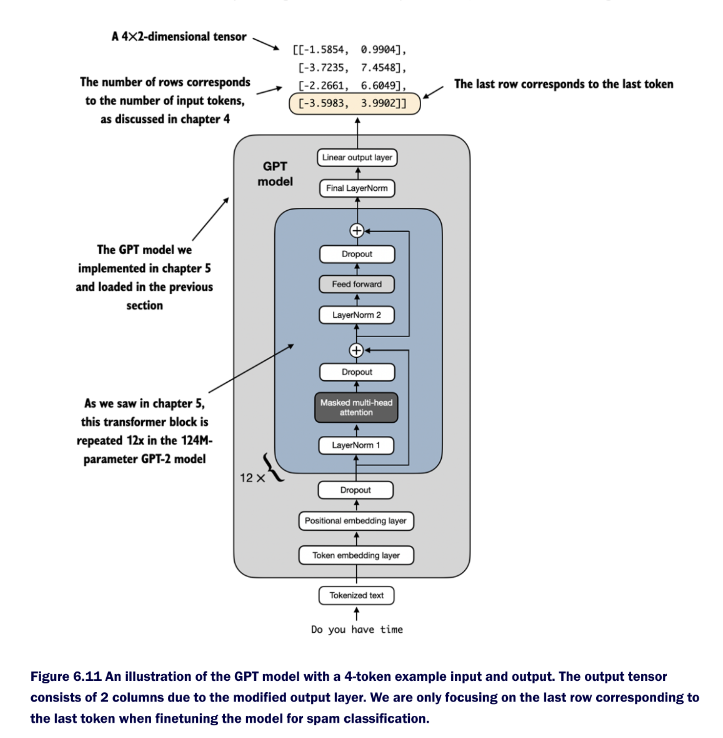

In [ ]:
# quello che usiamo per la predizione
print('Last output token:', outputs[:,-1,:])

## 6\.3\.1 Calculating the loss and accuracy

In [ ]:
# l'output viene calcolato sull'ultimo vettore logit dell'output
probas = torch.softmax(outputs[:,-1,:], dim = -1)
label = torch.argmax(probas)
print('Class label:', label.item())

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches = None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:,-1,:]
      predicted_labels = torch.argmax(logits, dim = -1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (
          (predicted_labels == target_batch).sum().item()
      )
    else:
      break
  return correct_predictions/num_examples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches = 10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches = 10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches = 10
)

print(f'Training accuracy: {train_accuracy*100:.2f}%')
print(f'Validation accuracy: {val_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  # gestione delle memoria
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  # Logits of last output token
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches == len(data_loader):
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      total_loss += loss.item()
    else:
      break
  # la loss viene calcolata come media sui batch
  return total_loss/num_batches


In [ ]:
with torch.no_grad():
  train_loss = calc_loss_loader(
      train_loader, model, device, num_batches = 5
  )
  val_loss = calc_loss_loader(
      val_loader, model, device, num_batches = 5
  )
  test_loss = calc_loss_loader(
      test_loader, model, device, num_batches = 5
  )

print(f"Training Loss: {train_loss:.3f}")
print(f"Validation Loss: {val_loss:.3f}")
print(f"Test Loss: {test_loss:.3f}")

## 6\.3\.2 Fine-tuning the model

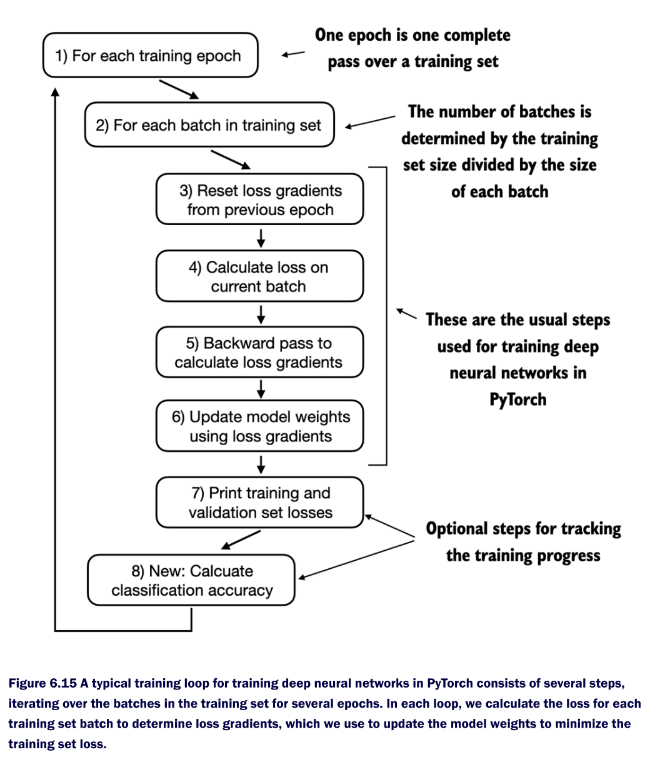

In [ ]:
def train_classifier_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter): # Added eval_iter parameter
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      loss.backward() # calcola il gradiente della loss in base al grafo computazione del modello
      optimizer.step() # aggiornamento dei parametri (step-wise method)
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0: # step di valutazione opzionale
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter # Passing eval_iter to evaluate_model
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}):"
        f"train loss {train_loss:3f}, "
        f"Val loss {val_loss:3f}")

    train_accuracy = calc_accuracy_loader(
        train_loader, model, device, num_batches = eval_iter
    )
    val_accuracy = calc_accuracy_loader(
        val_loader, model, device, num_batches = eval_iter
    )

    print(f"Training accuracy: {train_accuracy*100:.2f}")
    print(f"Validation accuracy: {val_accuracy*100:.2f}")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # disablita i layer di dropout
  with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches = eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches = eval_iter
      )
  model.train()
  return train_loss, val_loss

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq = 50, eval_iter = 5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f'Training completed in {execution_time_minutes:.2f} minutes')


In [ ]:
import matplotlib.pyplot as plt

def plot_values(
    epochs_seen, examples_seen, train_values, val_values, label = 'loss'
):
  fig, ax1 = plt.subplots(figsize = (5,3))
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
      epochs_seen, val_values, linestyle = "-.", label = f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha = 0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  plt.savefig(f'{label}-plt.pdf')
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label = "Accuracy")

# 6\.4 Model Review

In [ ]:
def classify_review(
    text, model ,tokenizer, device, max_length=None, pad_token_id = 50256
):
  model.eval()
  input_ids = tokenizer.encode(text)
  supported_context_length = model.pos_emb.weight.shape[1]
  input_ids = input_ids[:min(
      max_length, supported_context_length
  )]
  input_ids += [pad_token_id]*(max_length-len(input_ids)) # padding with endoftext token shorter than maximum threshold sequences
  input_tensor = torch.tensor(
      input_ids, device = device
  ).unsqueeze(0)

  with torch.no_grad():
    logits = model(input_tensor)[:,-1,:] # sequence classification uses only the last input logits vector
  predicted_label = torch.argmax(logits, dim = -1).item()

  return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

In [ ]:
text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)
print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

E interessante notare come questo modello fallisca nella classificazione di messaggi non in lingua inglese. Infatti il dataset di allenamento che abbiamo usato era formato da un testo in ingese.

In [ ]:
text_3 = (
    "Ciao!, hai appena vinto un milione di euro!"
)
print(classify_review(
text_3, model, tokenizer, device, max_length=train_dataset.max_length
))

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")